## Example B.3 Parent Breadth-first Search

Examples come from http://people.eecs.berkeley.edu/~aydin/GraphBLAS_API_C_v13.pdf

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import grblas as gb
from grblas import lib, ffi, Matrix, Vector, Scalar
from grblas.base import NULL, REPLACE
from grblas import dtypes
from grblas import descriptor
from grblas import UnaryOp, BinaryOp, Monoid, Semiring

In [2]:
def vrepr(v):
    df = pd.DataFrame(index=range(v.size), columns=[''])
    for i, val in zip(*v.to_values()):
        df.iloc[i] = val
    return df.where(pd.notnull(df), '')

def hrepr(v):
    return vrepr(v).T

def mrepr(m):
    df = pd.DataFrame(columns=range(m.ncols), index=range(m.nrows))
    for i, j, val in zip(*m.to_values()):
        df.iloc[i, j] = val
    return df.where(pd.notnull(df), '')

def draw(m):
    g = nx.DiGraph()
    for row, col, val in zip(*m.to_values()):
        g.add_edge(row, col, weight=val)
    pos = nx.spring_layout(g)
    edge_labels = {(i, j): d['weight'] for i, j, d in g.edges(data=True)}
    nx.draw_networkx(g, pos, node_color='red', node_size=500)
    #nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)

In [3]:
# Create initial data objects
edges = [
    [3,0,3,5,6,0,6,1,6,2,4,1],
    [0,1,2,2,2,3,3,4,4,5,5,6],
]
A = Matrix.new_from_values(edges[0], 
                           edges[1],
                          [True for _ in edges[0]])
s = 1

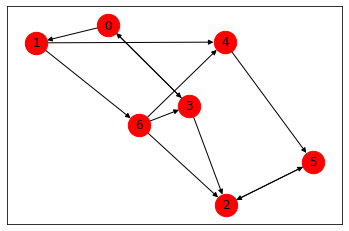

In [4]:
draw(A)

### parent breadth-first search (BFS) in GraphBLAS
```
1 #include <stdlib.h>
2 #include <stdio.h>
3 #include <stdint.h>
4 #include <stdbool.h>
5 #include ”GraphBLAS.h”
6
7 /∗
8  ∗ Given a binary n x n adjacency matrix A and a source vertex s, performs a BFS
9  ∗ traversal of the graph and sets parents[i] to the index i's parent.
10 ∗ The parent of the root vertex, s, will be set to itself (parents[s] == s). If
11 ∗ vertex i is not reachable from s, parents[i] will not contain a stored value.
12 ∗/
13 GrB_Info BFS(GrB_Vector *v, const GrB_Matrix A, GrB_Index s)
14 {
15   GrB_Index N;
16   GrB_Matrix nrows(&N, A); // N = # of rows of A
17
18   // create index ramp for index_of() functionality
19   GrB_Index *idx = (GrB_Index *) malloc (N*sizeof(GrB_Index));
20   for (GrB_Index i = 0; i < N; ++i) idx[i] = i;
21   GrB_Vector index_ramp;
22   GrB_Vector_new(&index_ramp, GrB_UINT64, N);
23   GrB_Vector_build_UINT64(index_ramp, idx, idx, N, GrB_PLUS_INT64);
24   free(idx);
25
26   GrB_Vector_new(parents, GrB_UINT64, N);
27   GrB_Vector_setElement(*parents, s, s); // parents[s] = s
28
29   GrB_Vector wavefront;
30   GrB_Vector_new(&wavefront, GrB_UINT64, N);
31   GrB_Vector_setElement(wavefront, 1UL, s); // wavefront[s] = 1
18   GrB_Vector_new(v, GrB_INT32, N) ; // Vector<int32_t> v(n) = 0
19
33   /∗
34    ∗ BFS traversal and label the vertices.
35    ∗/
36   GrB_Index nvals;
37   GrB_Vector_nvals(&nvals, wavefront);
38   
39   while (nvals > 0) 
40   {
41     // convert all stored values in wavefront to their 0−based index
42     GrB_eWiseMult(wavefront, GrB_NULL, GrB_NULL, GrB_FIRST_UINT64,
43     index_ramp, wavefront, GrB_NULL);
44
45     // ”FIRST” because left−multiplying wavefront rows. Masking out the parent
46     // list ensures wavefront values do not overwrite parents already stored.
47     GrB_vxm(wavefront, * parents, GrB_NULL, GrB_MIN_FIRST_SEMIRING_UINT64,
48             wavefront, A, GrB_DESC_RSC);
49
50     // Don’t need to mask here since we did it in mxm. Merges new parents in
51     // current wave front with existing parents : parents += wavefront
52     GrB_apply(* parents, GrB_NULL, GrB_PLUS_UINT64,
53     GrB_IDENTITY_UINT64, wavefront, GrB_NULL);
54
55     GrB_Vector_nvals(&nvals, wavefront);
56   }
57
58   GrB_free(&wavefront);
59   GrB_free(&index_ramp);
60
61   return GrB_SUCCESS;
62 }
```

## Python implementation

In [5]:
N = A.nrows
index_ramp = Vector.new_from_type(dtypes.UINT64, N)
index_ramp.rebuild_from_values(range(N), range(N))
parents = Vector.new_from_type(dtypes.UINT64, N)
parents.element[s] = s
wavefront = Vector.new_from_type(dtypes.UINT64, N)
wavefront.element[s] = 1

In [6]:
while wavefront.nvals > 0:
    # convert all stored values in wavefront to their 0−based index
    wavefront[:] = index_ramp.ewise_mult(wavefront, BinaryOp.FIRST)
    # ”FIRST” because left−multiplying wavefront rows. Masking out the parent
    # list ensures wavefront values do not overwrite parents already stored.
    wavefront[~parents, REPLACE] = wavefront.vxm(A, Semiring.MIN_FIRST)
    # Don’t need to mask here since we did it in mxm. Merges new parents in
    # current wave front with existing parents : parents += wavefront
    parents[BinaryOp.PLUS] = wavefront.apply(UnaryOp.IDENTITY)
hrepr(parents)

,0,1,2,3,4,5,6
,3,1,6,6,1,4,1


Let's Step thru each loop to watch the action unfold

In [7]:
# Only run this cell once -- it initializes things
parents.clear()
parents.element[s] = s
wavefront.clear()
wavefront.element[s] = 1

In [24]:
print('Proceed' if wavefront.nvals > 0 else 'Done')

Done


In [21]:
# convert all stored values in wavefront to their 0−based index
wavefront[:] = index_ramp.ewise_mult(wavefront, BinaryOp.FIRST)
hrepr(wavefront)

,0,1,2,3,4,5,6
,0,,,,,,


In [22]:
# ”FIRST” because left−multiplying wavefront rows. Masking out the parent
# list ensures wavefront values do not overwrite parents already stored.
wavefront[~parents, REPLACE] = wavefront.vxm(A, Semiring.MIN_FIRST)
hrepr(wavefront)

,0,1,2,3,4,5,6
,,,,,,,


In [23]:
# Don’t need to mask here since we did it in mxm. Merges new parents in
# current wave front with existing parents : parents += wavefront
parents[BinaryOp.PLUS] = wavefront.apply(UnaryOp.IDENTITY)
hrepr(parents)

,0,1,2,3,4,5,6
,3,1,6,6,1,4,1
